# **Convolutional neural network for brand's recognition**
# HSE project "Intellectual property"

**Цель проекта:** Распознавание интеллектуальной собственности на фотографии и выгрузка данных о ней из базы данных Spark-interfax.

**Входные данные:** Изображения с лого товарных знаков

**Выходные данные:**

Информация из базы данных Spark-interfax о распознанной на изображении компании (индекс платёжной дисциплины, индекс финансового риска, индекс должной осмотрительности).

**Выходные данные для бизнеса:**

Краткая бизнес-информация о контрагенте на основе изображения лого без необходимости дополнительных данных.

## *1. Import libraries for working with images and conv nets*

In [7]:
# Обработка данных
import numpy as np
import pandas as pd

# Отрисовка графиков
import matplotlib.pyplot as plt

# ML-моделирование
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Работа с изображениями
import cv2
from scipy.ndimage.filters import convolve
import skimage
import skimage.io
import skimage.transform
from skimage.color import gray2rgb
import imageio

import os

## *2. Image data loading*

First, we checked whether there are images in directory or not.

In [8]:
for filepath in os.listdir('C:/Users/Admin/ozon_cut/'):
    print(filepath)

ozon-1.png
ozon-10.jpg
ozon-100.png
ozon-101.jpg
ozon-102.jpg
ozon-103.jpg
ozon-104.jpg
ozon-105.jpg
ozon-106.png
ozon-107.jpg
ozon-108.jpg
ozon-109.jpg
ozon-11.jpg
ozon-110.jpg
ozon-111.jpg
ozon-112.jpg
ozon-113.jpg
ozon-114.jpg
ozon-115.jpg
ozon-116.jpg
ozon-117.png
ozon-118.jpg
ozon-119.jpg
ozon-12.jpg
ozon-120.jpg
ozon-121.jpg
ozon-122.jpg
ozon-123.jpg
ozon-124.jpg
ozon-125.jpg
ozon-126.jpg
ozon-127.png
ozon-128.jpg
ozon-129.jpg
ozon-13.jpg
ozon-130.jpg
ozon-131.jpg
ozon-132.jpg
ozon-133.jpg
ozon-134.jpg
ozon-135.jpg
ozon-136.jpg
ozon-137.jpg
ozon-138.jpg
ozon-139.jpg
ozon-14.jpg
ozon-140.png
ozon-141.JPG
ozon-142.JPG
ozon-143.jpg
ozon-144.jpg
ozon-145.jpg
ozon-146.jpg
ozon-147.png
ozon-148.png
ozon-149.jpg
ozon-15.png
ozon-150.jpg
ozon-151.jpg
ozon-152.jpg
ozon-153.jpg
ozon-154.jpg
ozon-155.png
ozon-156.jpg
ozon-157.jpg
ozon-158.jpg
ozon-159.jpg
ozon-16.jpg
ozon-160.jpg
ozon-161.jpg
ozon-162.jpg
ozon-163.jpg
ozon-164.png
ozon-165.jpg
ozon-166.jpg
ozon-167.jpg
ozon-168.jpg
ozon-169

Second, trying to upload images in jupiter in order to understand whether they can be readed correctly by python. Since cv2 library open images in BGR color scale by default, let's also transformed it into RGB scale for correct visualisation.

In [2]:
starbucks = []

# Load in the images
for filepath in os.listdir('C:/Users/Admin/Starbucks_301/'):
    starbucks.append(cv2.cvtColor(cv2.imread('C:/Users/Admin/Starbucks_301/{0}'.format(filepath),1),cv2.COLOR_BGR2RGB))

print(type(starbucks[0]))

<class 'numpy.ndarray'>


In [3]:
ozon = []

# Load in the images
for filepath in os.listdir('C:/Users/Admin/ozon_cut/'):
    ozon.append(cv2.cvtColor(cv2.imread('C:/Users/Admin/ozon_cut/{0}'.format(filepath),1),cv2.COLOR_BGR2RGB))

print(type(ozon[0]))

<class 'numpy.ndarray'>


In [5]:
invitro = []

# Load in the images
for filepath in os.listdir('C:/Users/Admin/Invitro/'):
    invitro.append(cv2.cvtColor(cv2.imread('C:/Users/Admin/Invitro/{0}'.format(filepath),1),cv2.COLOR_BGR2RGB))

print(type(invitro[0]))

<class 'numpy.ndarray'>


As we can see it works. Now we can make a dataframe with "file" column with names of original image files and apropriate class labels in "Brand" column:

In [10]:
import pandas as pd

In [186]:
Ozon = pd.DataFrame(os.listdir('C:/Users/Admin/ozon_cut/'), columns = ['file'])
Ozon['brand'] = 'ozon'
Dodo = pd.DataFrame(os.listdir('C:/Users/Admin/dodo_cut/'), columns = ['file'])
Dodo['brand'] = 'dodo'
Starbucks = pd.DataFrame(os.listdir('C:/Users/Admin/Starbucks_301/'), columns = ['file'])
Starbucks['brand'] = 'starbucks'
Invitro = pd.DataFrame(os.listdir('C:/Users/Admin/Invitro/'), columns = ['file'])
Invitro['brand'] = 'invitro'
Wildberries = pd.DataFrame(os.listdir('C:/Users/Admin/Wildberries_307/'), columns = ['file'])
Wildberries['brand'] = 'wildberries'

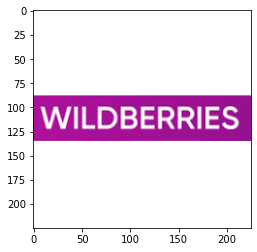

In [72]:
plt.imshow(wildberries[0])

In [187]:
data = pd.concat([Ozon, Dodo, Starbucks, Invitro, Wildberries], axis = 0)

In [188]:
data

file        brand
0             ozon-1.png         ozon
1            ozon-10.jpg         ozon
2           ozon-100.png         ozon
3           ozon-101.jpg         ozon
4           ozon-102.jpg         ozon
..                   ...          ...
302   Wildberries_95.png  wildberries
303  Wildberries_96.jpeg  wildberries
304  Wildberries_97.jpeg  wildberries
305  Wildberries_98.jpeg  wildberries
306  Wildberries_99.jpeg  wildberries

[1608 rows x 2 columns]

Now, we can check whether it is possible to use "file" column for getting images from path by adding row's string value of file name to the path to image files:

In [163]:
# Check whether image for some particular given discription exists
img_exists = data['file'].apply(lambda f: os.path.exists('C:/Users/Admin/logo/' + f))
data = data[img_exists]

In [164]:
img_exists

0      True
1      True
2      True
3      True
4      True
       ... 
302    True
303    True
304    True
305    True
306    True
Name: file, Length: 1608, dtype: bool

Obviously, we can.

## *3. Image preprocessing*

In that step I perform balancing of the dataset and image data augmentation in order to improve the quality of the model. First, the balancing procedure:

In [165]:
def split_balance(data, target):
    """ Balancing classes by undersampling """
    # Split to train and test before balancing
    train_data, test_data = train_test_split(data, random_state=24)

    # Split train to train and validation datasets
    train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=24)

    #Balance by subspecies to train_data_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_data)/len(train_data[target].unique()))
    train_data_bal = train_data.groupby(target, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_data_bal, val_data, test_data)

In [166]:
train_data_bal, val_data, test_data = split_balance(data, 'brand')

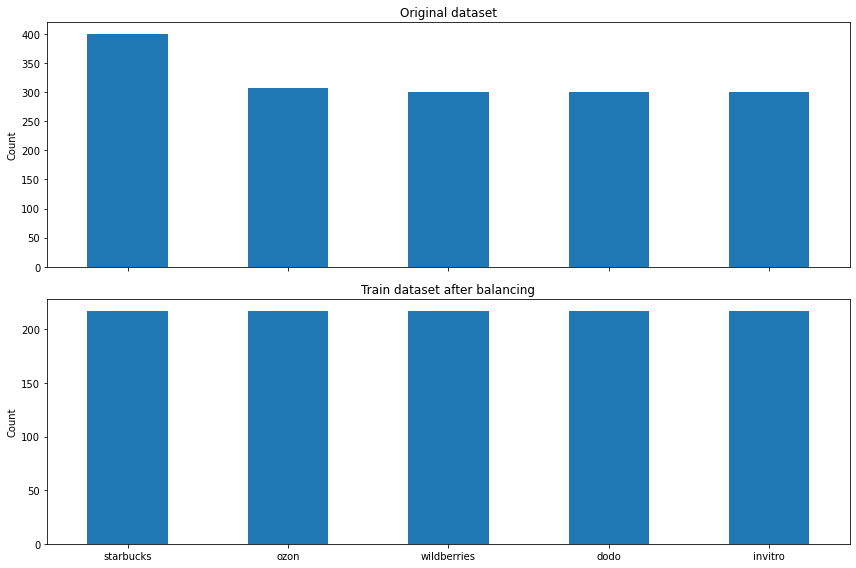

In [168]:
f, axs = plt.subplots(2,1, figsize=(12,8), sharex = True)

# Oridigan data
ax = data['brand'].value_counts().plot(kind='bar', rot = 0, ax=axs[0])
ax.set_title('Original dataset')
ax.set_ylabel('Count')

# Balanced train
ax = train_data_bal['brand'].value_counts().plot(kind='bar', rot = 0, ax=axs[1])
ax.set_title('Train dataset after balancing')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Now the dataset is completely balanced. It's time for data augmentation:

In [365]:
# Some default network parameters
IMAGE_WIDTH, IMAGE_HEIGHT = 100, 100
KERNEL_SIZE = 3
IMAGE_CHANNELS = 3
RANDOM_STATE = 1337
N_EPOCH = 30
BATCH_SIZE = 40
MAX_POOL_DIM = 2

In [366]:
def read_img(file, img_folder='C:/Users/Admin/logo/'):
    """ Reads images from the filepath in RGB format with resizing """
    
    # Using file column for getting image from the path
    img = skimage.io.imread(img_folder + file) 
    img = skimage.transform.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    
    #Transformation of gray pictures to color for equal tensors dimensionality
    img = gray2rgb(img) 
    return img[:,:,:IMAGE_CHANNELS]

In [5]:
import pandas as pd
import numpy as np

target = pd.DataFrame(['dodo','ozon','amazon'], columns = ['brand'])
target = pd.get_dummies(target['brand'], drop_first=False)
target

amazon  dodo  ozon
0       0     1     0
1       0     0     1
2       1     0     0

In [253]:
def prepare2train(train_data, val_data, test_data, target):
    """ Doing the following preparing procedures:
        a) Splitting data
        b) Data augmentation
    """
    
    # Brands already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels. 

    # Train data
    train_X = np.stack(train_data['file'].apply(read_img))
    train_y  = pd.get_dummies(train_data[target], drop_first=False)

    # Validation during training data to calculate val_loss metric
    val_X = np.stack(val_data['file'].apply(read_img))
    val_y = pd.get_dummies(val_data[target], drop_first=False)

    # Test data
    test_X = np.stack(test_data['file'].apply(read_img))
    test_y = pd.get_dummies(test_data[target], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
    generator.fit(train_X)
    return (generator, train_X, val_X, test_X, train_y, val_y, test_y)

In [220]:
generator, train_X, val_X, test_X, train_y, val_y, test_y = prepare2train(train_data_bal, val_data, test_data, 'brand')

<ipython-input-217-bd7483ef8277>:4: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  img = gray2rgb(img)


Finally, our images are ready for learning convolutional neural network.

## *4. Building the convolutional neural network model*

First i've developed model's architecture in form of 3-layers convolutional network with softmax activation in order to get probabilities of each class.

In [268]:
# We'll stop training if no improvement after some epochs
earlystopper1 = keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = keras.callbacks.ModelCheckpoint('best_model1.h5',
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True)
# Build CNN model
model1=Sequential()
model1.add(Conv2D(32, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(16, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(8, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(train_y.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [272]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 8)         1160      
_________________________________________________________________
flatten_6 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

Here machine learning starts:

In [269]:
training1 = model1.fit_generator(generator.flow(train_X,train_y, batch_size=BATCH_SIZE),
                                 epochs=N_EPOCH,
                                 validation_data=(val_X, val_y),
                                 steps_per_epoch=5,
                                 callbacks=[earlystopper1, checkpointer1]
                                )
# Get the best saved weights
model1.load_weights('best_model1.h5')

C:\Users\Admin\anaconda3\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
5/5 [==============================] - 7s 939ms/step - loss: 1.5609 - accuracy: 0.2859 - val_loss: 1.5304 - val_accuracy: 0.2893

Epoch 00001: val_accuracy improved from -inf to 0.28926, saving model to best_model1.h5
Epoch 2/30
5/5 [==============================] - 3s 661ms/step - loss: 1.4096 - accuracy: 0.4868 - val_loss: 1.3579 - val_accuracy: 0.5537

Epoch 00002: val_accuracy improved from 0.28926 to 0.55372, saving model to best_model1.h5
Epoch 3/30
5/5 [==============================] - 4s 671ms/step - loss: 1.2907 - accuracy: 0.5123 - val_loss: 1.2060 - val_accuracy: 0.4876

Epoch 00003: val_accuracy did not improve from 0.55372
Epoch 4/30
5/5 [==============================] - 4s 874ms/step - loss: 1.1226 - accuracy: 0.5245 - val_loss: 0.9514 - val_accuracy: 0.7355

Epoch 00004: val_accuracy improved from 0.55372 to 0.73554, saving model to best_model1.h5
Epoch 5/30
5/5 [==============================] - 4s 825ms/step - loss: 0.9175 - accuracy: 0.7215 - val_loss: 0

Now let's see in more detail what happened in each layer inside the network for different classes: I constracted the function which shows what patterns our network detects in images and uses for predictions.

In [273]:
def visualize_layer_kernels(img, conv_layer, title):
    """ Визуализирует свёртки скрытых слоёв свёрточной сети """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]
    
    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(10, kernels_num*4))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel=kernels[:,:,:3,i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize = 9)
        
        # Get and draw sample image from test data
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)
        
        # Filtered image - apply convolution
        img_filt = convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)
        
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

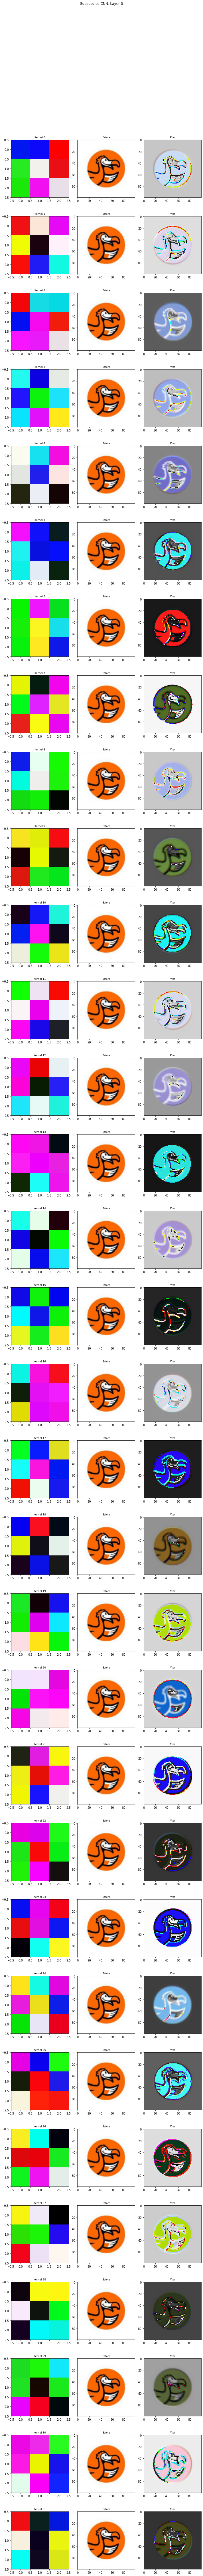

In [274]:
# Sample image to visualize convolution
idx = np.random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model1.layers[0]
img = visualize_layer_kernels(img, conv1, "Subspecies CNN. Layer 0")

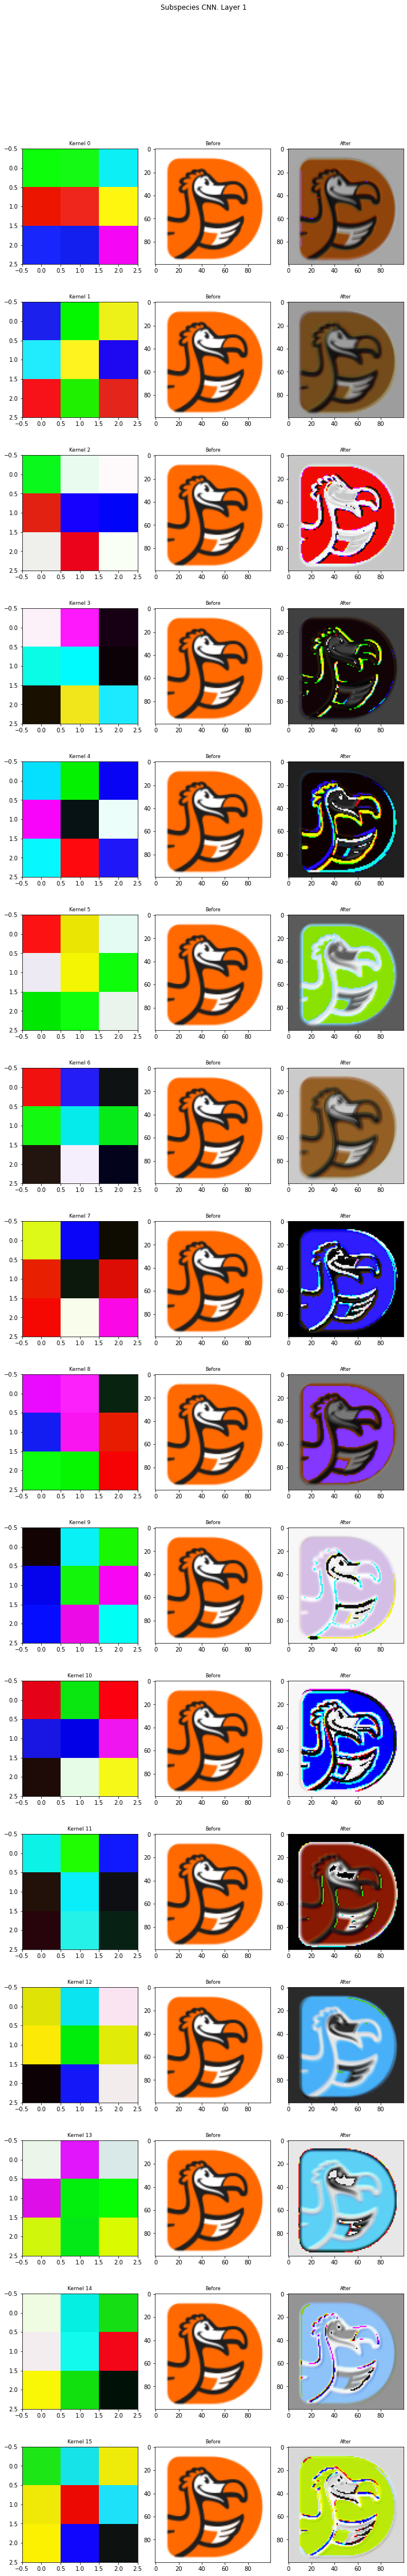

In [277]:
# Sample another image to visualize convolutoin
idx = np.random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model1.layers[2]
res = visualize_layer_kernels(img, conv2, "Subspecies CNN. Layer 1")

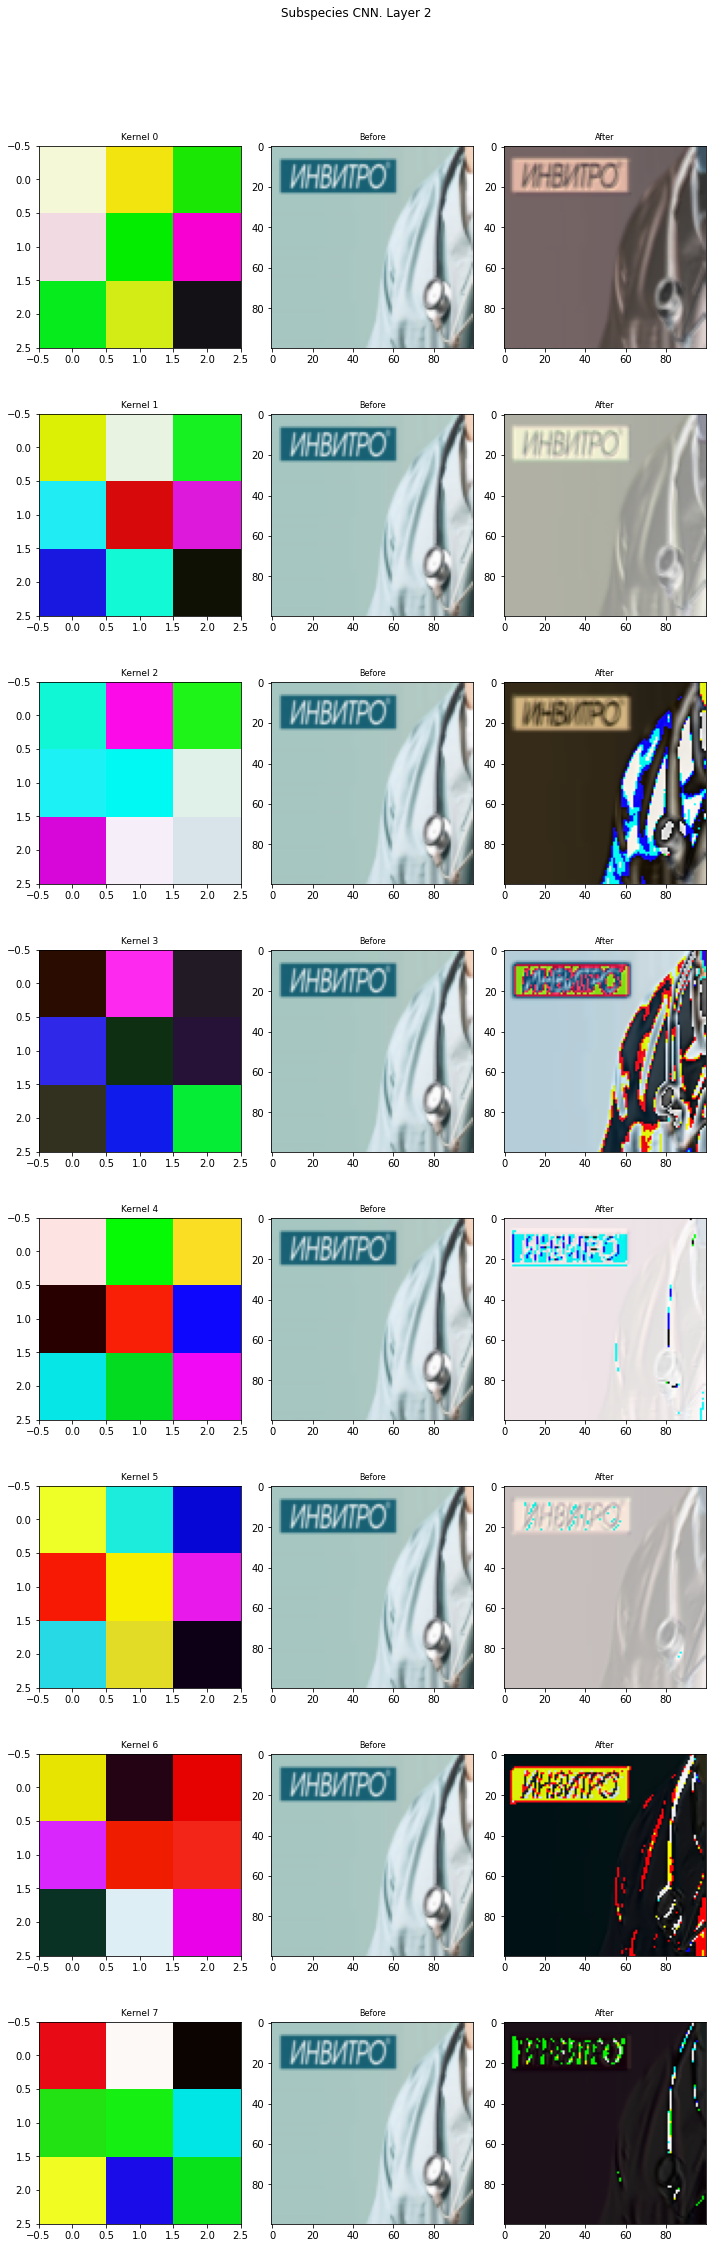

In [296]:
# Sample another image to visualize convolutoin
idx = np.random.randint(0,len(test_y)-1)
img = test_X[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv4 = model1.layers[4]
res = visualize_layer_kernels(img, conv4, "Subspecies CNN. Layer 2")

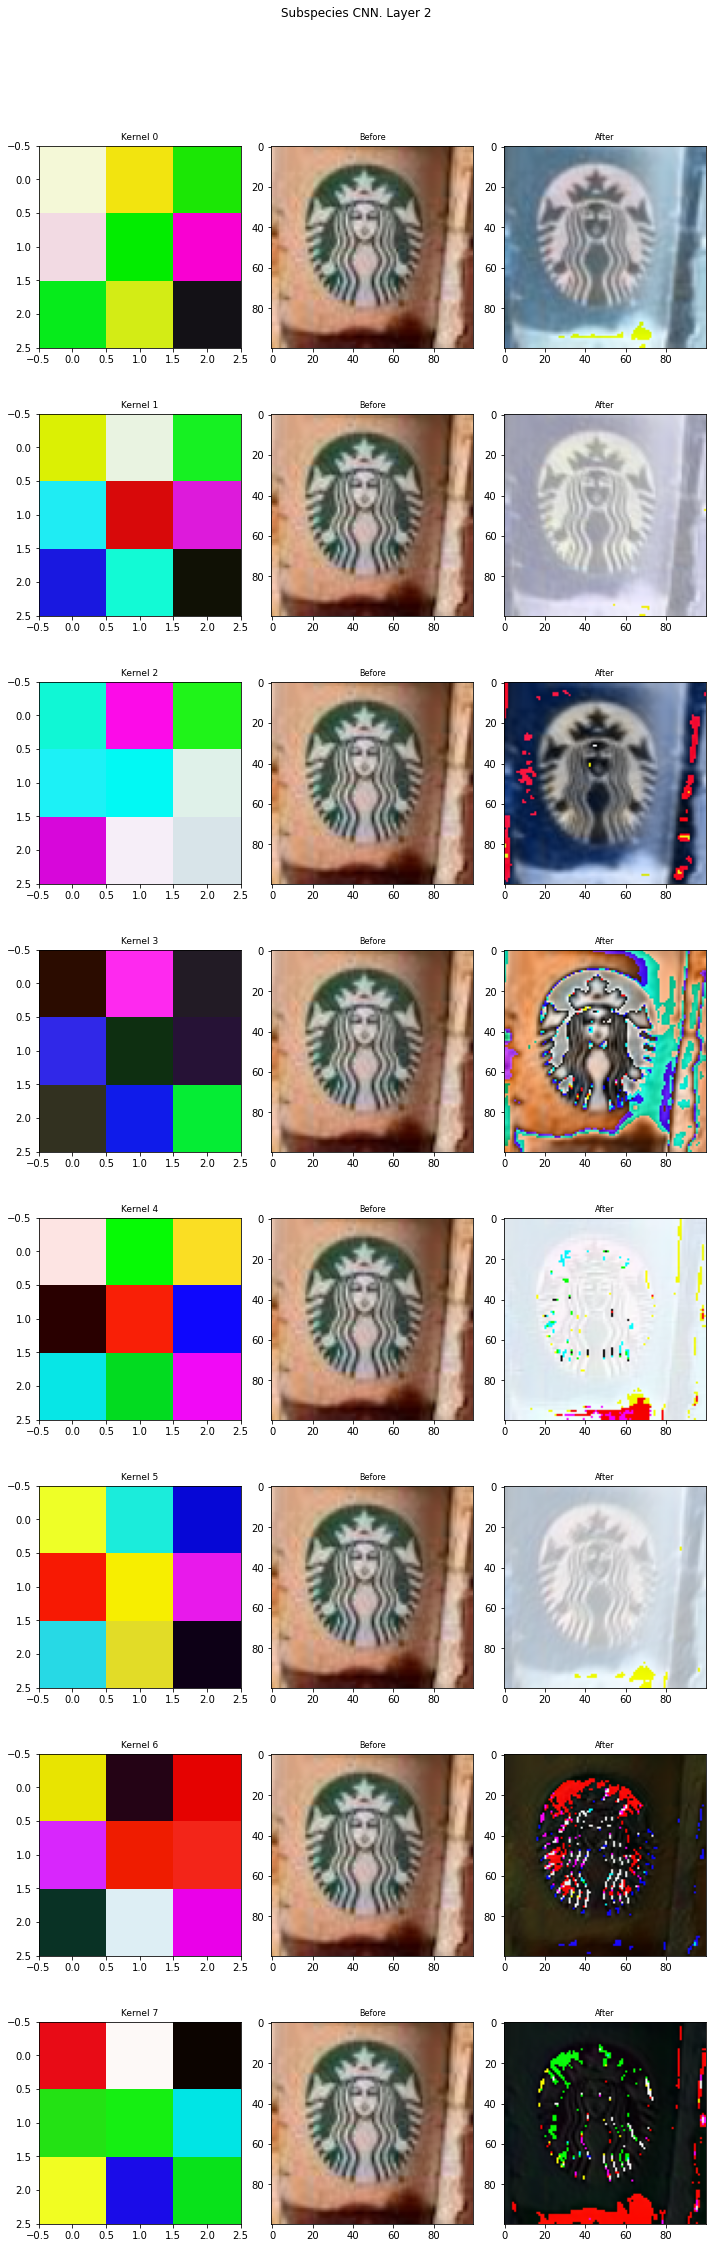

In [278]:
# Sample another image to visualize convolutoin
idx = np.random.randint(0,len(test_X)-1)
img = test_X[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv3 = model1.layers[4]
res = visualize_layer_kernels(img, conv3, "Subspecies CNN. Layer 2")

It's quite easy to understand now how our model works and makes it's predictions - it detects different structures and patterns in initial images using convolutions and kernels and uses it as a features for image classification. Based on the pictures above we can say that model is quite good performed.

## *5. Model evaluation*

At this final step we created a function for evaluation of the predictive power of our model in terms of such classification metrics as accuracy, F1 score, precision and recall with some nice graphical visualisation

In [270]:
def eval_model(training, model, test_X, test_y, target):
    """ Отрисовка процесса обучения сети"""
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2,1, figsize=(5,5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % target)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Accuracy
    ax[1].plot(training1.history['accuracy'], label="Accuracy")
    ax[1].plot(training1.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % target)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)    
    acc_by_subspecies = np.logical_and((test_pred > 0.5), test_y).sum()/test_y.sum()
    acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % target)
    plt.ylabel('Accuracy')
    plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(classification_report(test_truth, test_pred, target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

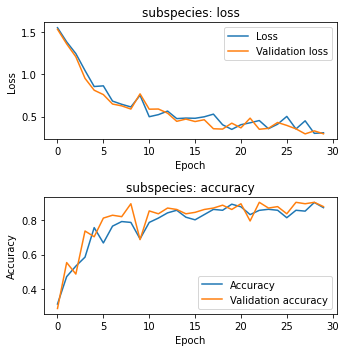

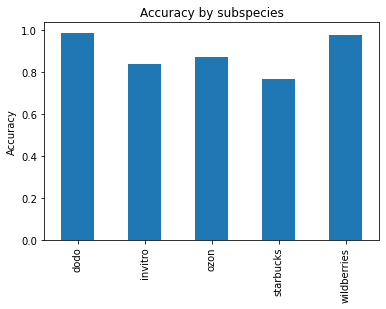

Classification report
              precision    recall  f1-score   support

        dodo       0.92      0.99      0.95        80
     invitro       0.90      0.88      0.89        94
        ozon       0.87      0.93      0.90        70
   starbucks       0.95      0.81      0.87        73
 wildberries       0.95      0.98      0.97        85

    accuracy                           0.92       402
   macro avg       0.92      0.92      0.92       402
weighted avg       0.92      0.92      0.92       402

Loss function: 0.31148841977119446, accuracy: 0.9179104566574097


In [271]:
eval_model(training1, model1, test_X, test_y, 'subspecies')

What we can say:

1) Accuracy - accuracy of the model is quite high and equals to 0,918 and changes not strongly from class to class perspective. However, it's not enough to analyze accuracy since it doesn't catch predictability from the point of view of covering different classes and balance of predictions so let's move on and see another more detailed classification metrics;

2) Recall - recall of the model is also quite high: for the most of the classes it's about 0.9 and only for starbucks is equal to 0.81. It means that the model covered each class fully enough.

3) Presicion is also quite high and equals to 0.92 in average. It means that the most part of positive classes recognized correctly.

4) F1-score is the harmonic mean of recall and precision so it serves as a final and generalized classification metric. It's about 0.93 in average and it's quite high.

Thus, we sucsessfully buit a convolutional neural network for logo recognition. Let's check it:

In [575]:
website = []

# Load in the images
for filepath in os.listdir('C:/Users/Admin/website/'):
    website.append(cv2.cvtColor(cv2.imread('C:/Users/Admin/website/{0}'.format(filepath),1),cv2.COLOR_BGR2RGB))

print(type(website[0]))

<class 'numpy.ndarray'>


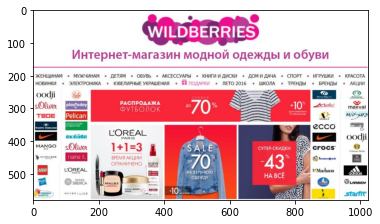

In [576]:
plt.imshow(website[1])

In [570]:
img = read_img('site.jpg', img_folder = 'C:/Users/Admin/website/')

<ipython-input-366-fd082162a7ba>:4: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  img = gray2rgb(img) #Transformation of gray pictures to color for equal tensors dimensionality


In [577]:
img = img.reshape(-1, 100, 100, 3)

In [578]:
model1.predict(img)

array([[0.01564524, 0.00987147, 0.04770709, 0.00451165, 0.9222646 ]],
      dtype=float32)

Model is correct.

## 6. Image segmentation K-means based model

Now lets build a model for detecting logos in websites for prediction of brand and it's scoring index. We used clustering K-means model for such a purpose.

In [299]:
!pip install kneed

In [4]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

C:\Users\kuchi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\kuchi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20

In [ ]:
pip install opencv-python
import cv2 
import urllib
import numpy as np

In [634]:
website = []

# Load in the images
for filepath in os.listdir('C:/Users/Admin/website/'):
    website.append(cv2.cvtColor(cv2.imread('C:/Users/Admin/website/{0}'.format(filepath),1),cv2.COLOR_BGR2RGB))

print(type(website[0]))

<class 'numpy.ndarray'>


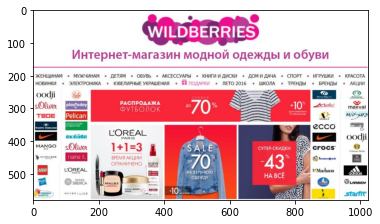

In [635]:
plt.imshow(website[1])

Let's perform a clustering. Before it we transformed initial image into an array for correct work.

In [636]:
pixel_vals = np.float32(website[1].reshape((-1,3)))

In [637]:
pixel_vals

array([[255., 255., 255.],
       [255., 255., 255.],
       [255., 255., 255.],
       ...,
       [254., 254., 252.],
       [254., 254., 252.],
       [254., 254., 252.]], dtype=float32)

In [679]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(pixel_vals)

KMeans(n_clusters=7)

Now we've got a segmented image with 5 pixel's clusters:

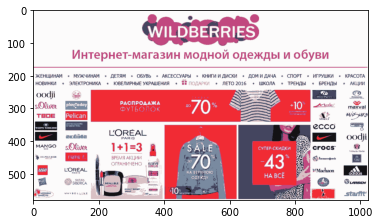

In [680]:
labels = kmeans.labels_
centers = np.uint8(kmeans.cluster_centers_)
segmented_data = centers[labels.flatten()] 
segmented_image = segmented_data.reshape((website[1].shape)) # reshape data into the original image dimensions 
plt.imshow(segmented_image)

For example, let's see in a chart with only one cluster:

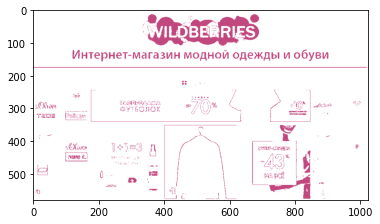

In [681]:
segmented_data1 = segmented_data.copy()
cluster = 1

for i in range(len(labels)):
    if labels[i]!=cluster:
        segmented_data1[i] = [255, 255, 255]
segmented_image1 = segmented_data1.reshape((website[1].shape)) # reshape data into the original image dimensions 
plt.imshow(segmented_image1)

In [401]:
segmented_image1

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

We can see that it's not fully the brand but it's enough for convolutional neural network model. Let's get every cluster of pixels as an input and based on maximal probabilities of prediction make a conclusion what is the brand and what is it's scoring metrics in accordance with SPARK database.

In [358]:
model1.load_weights('best_model1.h5')

In [ ]:
labels = kmeans.labels_
centers = np.uint8(kmeans.cluster_centers_)
segmented_data = centers[labels.flatten()] 
segmented_image = segmented_data.reshape((website[1].shape)) # reshape data into the original image dimensions 
plt.imshow(segmented_image)

segmented_data1 = segmented_data.copy()

cluster = 1
j=0
clusters = len(centers - 1)
segmented_images = []

for c in range(clusters):
    segmented_data1 = segmented_data.copy()
    for i in range(len(labels)):
        if labels[i]!=c:
            segmented_data1[i] = [255, 255, 255]
    segmented_image1 = segmented_data1.reshape((website[1].shape)) # reshape data into the original image dimensions
    segmented_images.append(segmented_image1)
    cv2.imwrite('C:/Users/Admin/website/website_' + str(c) + '.jpg', segmented_image1)
    
preds = {}

for c in range(clusters):
    image = read_img('website_' + str(c) + '.jpg', img_folder = 'C:/Users/Admin/website/')
    piece = model1.predict(image.reshape(-1, 100, 100, 3))
    preds[np.argmax(piece)] = np.max(piece)

recognized_franchize = fracnshize[max(preds.keys())]

## 7. Spark integration

In [3]:
from suds.client import Client
import xml.etree.ElementTree as ET

In [4]:
fracnshize = ['Dodo', 'Invitro', 'Ozon', 'Starbucks', 'Wildberries']
INN = {'Dodo': 1101140415,
          'Invitro': 7710294238,
          'Ozon': 7704217370,
          'Starbucks': 7810040438,
          'Wildberries': 7721546864}

# recognized_franchize = 'Dodo'

In [5]:
url = 'http://webservicefarm.interfax.ru/iFaxWebService/iFaxWebService.asmx?wsdl'
login = 'IVMGate'
password = 'qFMh0GI'

client = Client(url)

# Проверка работоспособности
result = client.service.Time()

# Подключение к шлюзу
result = client.service.Authmethod(Login=login, Password=password)

inn_rec = INN[recognized_franchize]

# Пример вызова функции
result = client.service.GetCompanyRiskFactors(inn=inn_rec)
root = ET.fromstring(result.xmlData)

# Отключение от шлюза
client.service.End()

True

In [6]:
for child in root.iter():
    if child.tag == 'IndexOfDueDiligence':
        IDO_score =  child.items()[0][1]
        IDO_name = child.items()[1][1]
    elif child.tag == 'FailureScore':
        FS_score =  child.items()[0][1]
        FS_name = child.items()[1][1]
    elif child.tag == 'PaymentIndex':
        PI_score =  child.items()[0][1]
        PI_name = child.items()[1][1]
    elif child.tag == 'ConsolidatedIndicator':
        CI_name = child.items()[0][1]

In [10]:
print('--------------------------- Reckognized info ---------------------------')
print('The {} logotip has been reckognized in the website. The scoring score:\nIndex Of DueDiligence is {} - {}, Failure Score is {} - {}, Payment Index is {} - {}, Consolidated risk - {} (according to the SPARK database).'.format(recognized_franchize,
                                                                                                                            IDO_score, IDO_name, FS_score, FS_name, PI_score, PI_name, CI_name))

--------------------------- Reckognized info ---------------------------
The Dodo logotip has been reckognized in the website. The scoring score:
Index Of DueDiligence is 1 - Низкий риск, Failure Score is 10 - Низкий риск, Payment Index is 85 - Низкий риск просрочки платежа, Consolidated risk - Low (according to the SPARK database).
